# Satellite Image Processing - Spectral Indices

## Soil-Adjusted Vegetation Index (SAVI)

The **spectral indices** are calculated through mathematical combinations of the **reflectances** presented in the image bands. Among the **vegetation indices**, the **Normalized Difference Vegetation Index (NDVI)** is widely used, but there are other indices that can contribute to research/study/work. 

---*For ***NDVI calculation***, please refer to my previous notebook in this repository.*---

One of these indexes is the **Soil-Adjusted Vegetation Index (SAVI)**, which takes into account the effects of exposed soil in the analyzed images. This index introduces an **adjustment factor (L)** to the **NDVI** seeking to minimize the effects of soil presence. **L** is a constant with values in the range of **0.25 to 1**, depending on the soil coverage. Please, check [USGS](https://www.usgs.gov/core-science-systems/nli/landsat/landsat-soil-adjusted-vegetation-index).

The equation for **SAVI calculation** is presented below:


<img src='jpg/SAVI_equation.jpg' />

As SAVI is a sort of adjusted NDVI,we can expect SAVI values in the range of -1 to 1, meaning values **closer to 1**, the **greater** the **presence of vegetation** (or **healthier vegetation**), and **closer to -1**, the **greater** the **presence of bare soils and rocks** (or **unhealthy vegetation**).

Both the **SAVI calculation** and the **value of L** were based on literatute review, **Somvanshi and Kumari (2020)**, and **Huete (1988)**. See below.

* Somvanshi S. S. and Kumari, M. (2020). Comparative analysis of different vegetation indices with respect to atmospheric particulate pollution using sentinel data. *Applied Computing and Geosciences*,7,100032,ISSN 2590-1974. https://doi.org/10.1016/j.acags.2020.100032.<br>


* Huete, A.R. (1988). A soil-adjusted vegetation index (SAVI). *Remote Sensing of Environment*,25,3,295-309.
https://doi.org/10.1016/0034-4257(88)90106-X<br>

According to **Huete (1988)**, a value for L of 0.25 is indicated for dense vegetation, 0.5 for vegetation with intermediate density and values close to 1 for vegetation with low density. 

In our example we will use **L = 0.5**.

---

## SAVI Calculation using Sentinel-2 imagery

In the previous notebook, when we calculated **NDVI**, we had already created a raster composite for our **Sentinel-2 imagery** example on the Province of Utrecht in the Netherlands. 

Right now, we will use the same input to calculate **SAVI** for the same area. Let's remember how our composite image looks like:


                                                 -Raster composite with 4 bands-

|   Band number of our composite    |   Band number of Sentinel-2    |
| :-------------------------------: | :----------------------------: |
|             Band 1 - Red          |          Band 4 - Red          |
|             Band 2 - Green        |          Band 3 - Green        |
|             Band 3 - Blue         |          Band 2 - Blue         |
|    Band 4 - Nir (Near-infrared)   |  Band 8 - Nir (Near-infrared)  |

In [1]:
# importing necessary libraries

import rasterio
from rasterio import plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Getting path directory
imagePath = "./data/"

As previously explained, in our raster dataset we have **a total of 4 bands** from Sentinel-2. When we build up this composite we assigned the **red band** to **band number 1** and the **NIR (near-infrared) band** to **number 4**. 

For the **SAVI** calculation we will need to parse and read only these two bands from our raster composite.

In [3]:
# opening the dataset with rasterio
utrecht_tiff = rasterio.open(imagePath+'clipped_S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_4bands.tiff',driver='Gtiff')

# reading bands Red and NIR into numpy arrays
band_red = utrecht_tiff.read(1)
band_nir = utrecht_tiff.read(4)

Usually, **SAVI values** range from **-1 to 1**, but we can also achieve values **outside this range**. In this example, our images are a **atmospheric corrected product**, but while important, corrected images can also bring some noise to the **red band**. It may have a **reflectance** much lower than the **Top of Atmosphere reflectance (TOA)**. More information on this you can find [here](https://labo.obs-mip.fr/multitemp/using-ndvi-with-atmospherically-corrected-data/).

In [4]:
# allowing division by zero
np.seterr(divide='ignore', invalid='ignore')

L = 0.5; # L = soil brightness correction factor could range from (0 -1)

savi = ((band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red + L) * (1.0 + L))

Let's take a look at the range of values:

In [5]:
# quick check on calculated SAVI values
print(np.nanmin(savi)) 
print(np.nanmax(savi))

-1.4981905910735827
1.4996074326092645


We will do a workaround to normalize these values, following the suggestion made in the above article and **add 0.05 constant** to our **SAVI equation**.

In [6]:
# allowing division by zero
np.seterr(divide='ignore', invalid='ignore')

L = 0.5; # L = soil brightness correction factor could range from (0 -1)

savi = (((band_nir.astype(float) - band_red.astype(float))+0.05) / ((band_nir + band_red + L) * (1.0 + L))+0.05)

Let's see the results now.

In [7]:
# quick check on calculated SAVI values
print(np.nanmin(savi)) 
print(np.nanmax(savi))

-0.6157820667470848
0.7164956817587019


### Writing/Saving SAVI image

As we are satisfied with our results, let's save our this file as a **new tiff**. First, we will give the same **metadata** of our **input raster composite**.

In [8]:
# getting the metadata of the input tiff
meta = utrecht_tiff.meta
print(meta)

# retrieving the dtype from our NDVI
savi_dtype = savi.dtype
print(savi_dtype)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 5797, 'height': 4955, 'count': 4, 'crs': CRS.from_epsg(32631), 'transform': Affine(10.0, 0.0, 622570.0,
       0.0, -10.0, 5796720.0)}
float64


In [9]:
# creating kwargs variable from meta
kwargs = meta

# updating the count value
kwargs.update(count=1)

In [10]:
# saving new raster file
with rasterio.open(imagePath+'clipped_S2A_MSIL2A_20200420T105031_N0214_R051_T31UFT_SAVI.tiff', 'w', **kwargs) as dst:
        dst.write(savi, 1)

---

### Displaying the SAVI image

As a last step in this notebook, we can plot our **SAVI results**. Let's use ***matplotlib*** to visualize it.

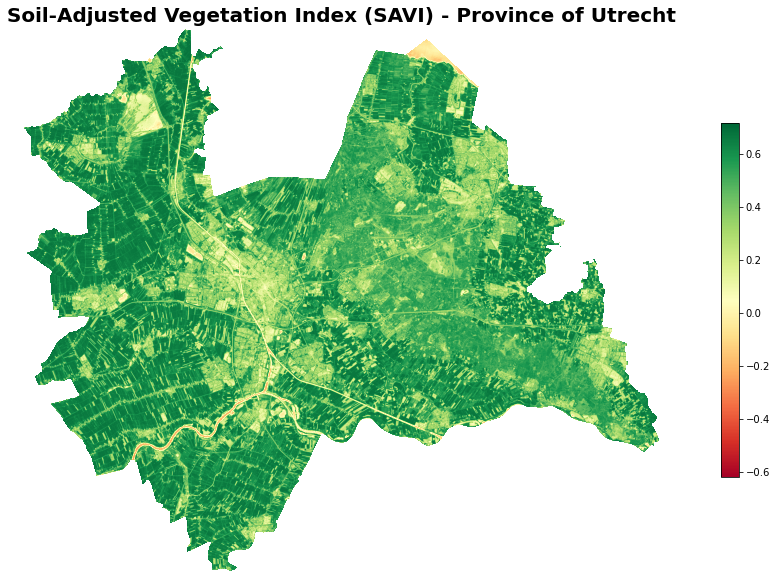

In [11]:
plt.figure(figsize=(22,10))
fig = plt.imshow(savi, cmap='RdYlGn',)
plt.colorbar(shrink=0.65)
plt.title('Soil-Adjusted Vegetation Index (SAVI) - Province of Utrecht', loc='center',fontsize=20, fontweight='bold')
plt.axis('off')
# Displaying the results.
plt.show()